In [1265]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import VotingRegressor
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import optuna

import warnings
warnings.filterwarnings("ignore")

In [1266]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#sub = pd.read_csv('sample_submission.csv')

In [1267]:
train

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km)
0,1,MITSU,SUV - SMALL,1.5,4.0,AV8,X,8.40 km/L,0.72 L/10km,0.98 L/10km,208
1,2,TOYOTI,PICKUP TRUCK - SMALL,not-available,6.0,A5,X,7.25 km per L,9.70 L/100km,11.96 L/100km,325
2,3,MATSUDA,COMPACT,2.0,4.0,AS6,X,9.80 km/L,38.70 mpg Imp.,31.76 mpg Imp.,170
3,4,CHEVO,VAN - PASSENGER,unknown,8.0,A6,X,1.73 L/10km,11.70 liters per 100 km,14.78 liters per 100 km,362
4,5,TOYOTI,COMPACT,1.8,4.0,M6,X,8.10 L/100km,35.76 mpg Imp.,8.01 liters per 100 km,180
...,...,...,...,...,...,...,...,...,...,...,...
54932,54933,CHEVO,SUBCOMPACT,6.2,8.0,AS10,Z,11.90 L/100km,11.36 km per L,22.39 MPG (AS),318
54933,54934,CHEVO,SUBCOMPACT,3.6,6.0,M6,X,2.10 L/10km,1.06 L/10km,14.41 MPG (AS),303
54934,54935,FOLD,TWO-SEATER,3.5,6.0,AM7,Z,18.20 L/100km,12.50 L/100km,15.63 L/100 km,410
54935,54936,CHEVO,PICKUP TRUCK - STANDARD,6.2,8.0,A8,Z,18.30 L/100 km,9.90 liters per 100 km,14.52 L/100 km,466


In [1268]:
test

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb
0,54938,FOLD,PICKUP TRUCK - STANDARD,5.0,8.0,AS10,X,14.20 liters per 100 km,15.20 liters per 100 km,16.06 MPG (AS)
1,54939,BMV,COMPACT,2.0,4.0,A8,Z,9.10 L/100 km,43.46 mpg Imp.,29.66 MPG (AS)
2,54940,JIPU,SUV - SMALL,1.3,4.0,A9,X,27.69 mpg Imp.,7.80 liters per 100 km,9.12 liters per 100 km
3,54941,LECUS,SUV - SMALL,not-recorded,4.0,AS6,Z,NaN,26.43 MPG (AS),NaN
4,54942,BARUSU,COMPACT,2.0,unestablished,M6,Z,11.36 km/L,39.79 mpg Imp.,8.04 L/100km
...,...,...,...,...,...,...,...,...,...,...
23540,78478,MITSU,SUV - SMALL,2.0,4.0,M5,X,NaN,13.33 km/L,8.98 L/100km
23541,78479,CHEVO,COMPACT,1.4,4.0,M6,X,27.04 MPG (AS),18.18 km per L,0.73 L/10km
23542,78480,KIO,SUV - SMALL,unknown,4.0,AS6,X,11.60 L/100km,8.40 liters per 100 km,9.84 km per L
23543,78481,JIPU,SUV - SMALL,2.4,4.0,A9,X,9.52 km/L,0.84 L/10km,0.96 L/10km


In [1269]:
def konversi(df, col):
    df[col] = df[col].str.replace(' ', '')
    df[col] = df[col].str.replace('litersper100km', '')
    df[col] = df[col].str.replace('L/100km', '')
    df[col] = df[col].str.replace('L/10km', '*10')#'/10')
    df[col] = df[col].str.replace('MPG(AS)', '**(-1)* 235.21')
    df[col] = df[col].str.replace('km/L', '')#**(-1) /100')
    df[col] = df[col].str.replace('kmperL', '')#'**(-1) /100')
    df[col] = df[col].str.replace('mpgImp.', '**(-1)* 282.48')
    df[col] = df[col].str.replace('not-available', '-1')
    df[col] = df[col].str.replace('zero', '0')
    df[col] = df[col].fillna("-1")
    for idx in df.index:
        df.at[idx, col] = eval(df.at[idx, col])
    df[col] = df[col].astype(float)
    df[col].values[df[col] > 100] = np.nan
    df[col].values[df[col] < 0] = np.nan

In [1270]:
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    df[col].values[(df[col] < q1 - 1.5*iqr) | (df[col] > q3 + 1.5*iqr)] = np.nan

In [1271]:
konversi(train, 'Fuel Consumption City')
konversi(train, 'Fuel Consumption Hwy')
konversi(train, 'Fuel Consumption Comb')
konversi(test, 'Fuel Consumption City')
konversi(test, 'Fuel Consumption Hwy')
konversi(test, 'Fuel Consumption Comb')

In [1272]:
remove_outliers(train, 'Fuel Consumption City')
remove_outliers(train, 'Fuel Consumption Hwy')
remove_outliers(train, 'Fuel Consumption Comb')
remove_outliers(test, 'Fuel Consumption City')
remove_outliers(test, 'Fuel Consumption Hwy')
remove_outliers(test, 'Fuel Consumption Comb')

In [1273]:
train['Comb Imputed'] = train['Fuel Consumption Comb'].isnull()
train['City Imputed'] = train['Fuel Consumption City'].isnull()
train['Hwy Imputed'] = train['Fuel Consumption Hwy'].isnull()

In [1274]:
test['Comb Imputed'] = test['Fuel Consumption Comb'].isnull()
test['City Imputed'] = test['Fuel Consumption City'].isnull()
test['Hwy Imputed'] = test['Fuel Consumption Hwy'].isnull()

In [1275]:
# train.loc[~(train['Fuel Consumption City'].isnull()) & ~(train['Fuel Consumption Hwy'].isnull()) & (train['Fuel Consumption Comb'].isnull()), 'Fuel Consumption Comb'] = (train['Fuel Consumption City']+train['Fuel Consumption Hwy'])/2
# train.loc[(train['Fuel Consumption City'].isnull()) & ~(train['Fuel Consumption Hwy'].isnull()) & ~(train['Fuel Consumption Comb'].isnull()), 'Fuel Consumption City'] = (2*train['Fuel Consumption Comb']-train['Fuel Consumption Hwy'])
# train.loc[~(train['Fuel Consumption City'].isnull()) & (train['Fuel Consumption Hwy'].isnull()) & ~(train['Fuel Consumption Comb'].isnull()), 'Fuel Consumption Hwy'] = (2*train['Fuel Consumption Comb']-train['Fuel Consumption City'])

In [1276]:
# test.loc[~(test['Fuel Consumption City'].isnull()) & ~(test['Fuel Consumption Hwy'].isnull()) & (test['Fuel Consumption Comb'].isnull()), 'Fuel Consumption Comb'] = (test['Fuel Consumption City']+test['Fuel Consumption Hwy'])/2
# test.loc[(test['Fuel Consumption City'].isnull()) & ~(test['Fuel Consumption Hwy'].isnull()) & ~(test['Fuel Consumption Comb'].isnull()), 'Fuel Consumption City'] = abs(2*test['Fuel Consumption Comb']-test['Fuel Consumption Hwy'])
# test.loc[~(test['Fuel Consumption City'].isnull()) & (test['Fuel Consumption Hwy'].isnull()) & ~(test['Fuel Consumption Comb'].isnull()), 'Fuel Consumption Hwy'] = abs(2*test['Fuel Consumption Comb']-test['Fuel Consumption City'])

In [1277]:
train

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,CO2 Emissions(g/km),Comb Imputed,City Imputed,Hwy Imputed
0,1,MITSU,SUV - SMALL,1.5,4.0,AV8,X,8.40,7.200000,9.800000,208,False,False,False
1,2,TOYOTI,PICKUP TRUCK - SMALL,not-available,6.0,A5,X,7.25,9.700000,11.960000,325,False,False,False
2,3,MATSUDA,COMPACT,2.0,4.0,AS6,X,9.80,7.299225,8.894207,170,False,False,False
3,4,CHEVO,VAN - PASSENGER,unknown,8.0,A6,X,17.30,11.700000,14.780000,362,False,False,False
4,5,TOYOTI,COMPACT,1.8,4.0,M6,X,8.10,7.899329,8.010000,180,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54932,54933,CHEVO,SUBCOMPACT,6.2,8.0,AS10,Z,11.90,11.360000,10.505136,318,False,False,False
54933,54934,CHEVO,SUBCOMPACT,3.6,6.0,M6,X,21.00,10.600000,16.322693,303,False,False,False
54934,54935,FOLD,TWO-SEATER,3.5,6.0,AM7,Z,18.20,12.500000,15.630000,410,False,False,False
54935,54936,CHEVO,PICKUP TRUCK - STANDARD,6.2,8.0,A8,Z,18.30,9.900000,14.520000,466,False,False,False


In [1278]:
def remove_unknown(df, col):
    for unknown in ['unspecified', 'missing', 'not-available', 'not-recorded', 'unknown', 'unestablished', '-1', 'na']:
        df[col].values[df[col] == unknown] = np.nan

In [1279]:
for col in train.columns[2:7]:
    remove_unknown(train, col)
    remove_unknown(test, col)

In [1280]:
for col in train.columns:
    print(train[col].unique())

[    1     2     3 ... 54935 54936 54937]
['MITSU' 'TOYOTI' 'MATSUDA' 'CHEVO' 'DOGE' 'BMV' 'LECUS' 'KIO' 'FOLD'
 'JIPU' 'NIRRAN' 'CADILUXE' 'FOLKSWA' 'BARUSU' 'GONDA' 'LAND CRAWLER'
 'RYUNDAI' 'TOLVO' 'FIAR' 'ASURA' 'LAMBOGI']
['SUV - SMALL' 'PICKUP TRUCK - SMALL' 'COMPACT' 'VAN - PASSENGER'
 'MID-SIZE' 'SUV - STANDARD' 'STATION WAGON - SMALL' 'FULL-SIZE'
 'TWO-SEATER' 'PICKUP TRUCK - STANDARD' 'SUBCOMPACT' nan
 'STATION WAGON - MID-SIZE' 'MINICOMPACT' 'MINIVAN'
 'SPECIAL PURPOSE VEHICLE' 'VAN - CARGO']
['1.5' nan '2.0' '1.8' '2.4' '3.5' '2.7' '1.6' '1.2' '2.5' '3.2' '5.0'
 '8.4' '1.4' '3.8' '6.2' '4.4' '3.0' '3.6' '5.7' '5.2' '6.4' '2.3' '3.3'
 '5.3' '6.5' '1.0' '4.0' '3.7' '1.3' '4.6' '4.8' '5.6' '2.8' '6.0' '4.2'
 '4.3' '2.2' '6.6' '5.4' '3.4' '5.8' '6.8']
['4.0' '6.0' '8.0' nan '3.0' '10.0' '12.0' '5.0']
['AV8' 'A5' 'AS6' 'A6' 'M6' 'M5' 'A9' 'AS8' 'AV' 'AM6' 'AS10' 'A8' 'AS9'
 nan 'AM8' 'AM7' 'AV7' 'A4' 'AV6' 'AV10' 'AS5' 'M7' 'A10' 'AS7' 'A7' 'AM9']
['X' 'Z' nan 'E' 'D' 'N']
[ 8.4

In [1281]:
train.isna().sum()

Id                          0
Make                        0
Vehicle Class            2051
Engine Size(L)           5264
Cylinders                4523
Transmission             1483
Fuel Type                1942
Fuel Consumption City    3408
Fuel Consumption Hwy     3334
Fuel Consumption Comb    3562
CO2 Emissions(g/km)         0
Comb Imputed                0
City Imputed                0
Hwy Imputed                 0
dtype: int64

In [1282]:
train['Transmission Imputed'] = train['Transmission'].isnull()
test['Transmission Imputed'] = test['Transmission'].isnull()

In [1283]:
train["Transmission"] = train["Transmission"].fillna(
    train["Transmission"].mode()[0])
test["Transmission"] = test["Transmission"].fillna(
    test["Transmission"].mode()[0])

In [1284]:
train[['TransmisiHuruf', 'TransmisiAngka']] = train['Transmission'].str.extract('([A-Za-z]+)([0-9]+)?', expand=True)
test[['TransmisiHuruf', 'TransmisiAngka']] = test['Transmission'].str.extract('([A-Za-z]+)([0-9]+)?', expand=True)

In [1285]:
train['TransmisiHurufPisah'] = train['TransmisiHuruf'].str[0]
test['TransmisiHurufPisah'] = test['TransmisiHuruf'].str[0]

In [1286]:
train['TransmissionImputed'] = train['Transmission'].isnull()
train['TransmisiHurufImputed'] = train['TransmisiHuruf'].isnull()
train['TransmisiAngkaImputed'] = train['TransmisiAngka'].isnull()
train['TransmisiHurufPisahImputed'] = train['TransmisiHurufPisah'].isnull()

In [1287]:
test['TransmissionImputed'] = test['Transmission'].isnull()
test['TransmisiHurufImputed'] = test['TransmisiHuruf'].isnull()
test['TransmisiAngkaImputed'] = test['TransmisiAngka'].isnull()
test['TransmisiHurufPisahImputed'] = test['TransmisiHurufPisah'].isnull()

In [1288]:
train

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,...,City Imputed,Hwy Imputed,Transmission Imputed,TransmisiHuruf,TransmisiAngka,TransmisiHurufPisah,TransmissionImputed,TransmisiHurufImputed,TransmisiAngkaImputed,TransmisiHurufPisahImputed
0,1,MITSU,SUV - SMALL,1.5,4.0,AV8,X,8.40,7.200000,9.800000,...,False,False,False,AV,8,A,False,False,False,False
1,2,TOYOTI,PICKUP TRUCK - SMALL,NaN,6.0,A5,X,7.25,9.700000,11.960000,...,False,False,False,A,5,A,False,False,False,False
2,3,MATSUDA,COMPACT,2.0,4.0,AS6,X,9.80,7.299225,8.894207,...,False,False,False,AS,6,A,False,False,False,False
3,4,CHEVO,VAN - PASSENGER,NaN,8.0,A6,X,17.30,11.700000,14.780000,...,False,False,False,A,6,A,False,False,False,False
4,5,TOYOTI,COMPACT,1.8,4.0,M6,X,8.10,7.899329,8.010000,...,False,False,False,M,6,M,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54932,54933,CHEVO,SUBCOMPACT,6.2,8.0,AS10,Z,11.90,11.360000,10.505136,...,False,False,False,AS,10,A,False,False,False,False
54933,54934,CHEVO,SUBCOMPACT,3.6,6.0,M6,X,21.00,10.600000,16.322693,...,False,False,False,M,6,M,False,False,False,False
54934,54935,FOLD,TWO-SEATER,3.5,6.0,AM7,Z,18.20,12.500000,15.630000,...,False,False,False,AM,7,A,False,False,False,False
54935,54936,CHEVO,PICKUP TRUCK - STANDARD,6.2,8.0,A8,Z,18.30,9.900000,14.520000,...,False,False,False,A,8,A,False,False,False,False


In [1289]:
test

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,...,City Imputed,Hwy Imputed,Transmission Imputed,TransmisiHuruf,TransmisiAngka,TransmisiHurufPisah,TransmissionImputed,TransmisiHurufImputed,TransmisiAngkaImputed,TransmisiHurufPisahImputed
0,54938,FOLD,PICKUP TRUCK - STANDARD,5.0,8.0,AS10,X,14.200000,15.200000,14.645704,...,False,False,False,AS,10,A,False,False,False,False
1,54939,BMV,COMPACT,2.0,4.0,A8,Z,9.100000,6.499770,7.930209,...,False,False,False,A,8,A,False,False,False,False
2,54940,JIPU,SUV - SMALL,1.3,4.0,A9,X,10.201517,7.800000,9.120000,...,False,False,False,A,9,A,False,False,False,False
3,54941,LECUS,SUV - SMALL,NaN,4.0,AS6,Z,NaN,8.899357,NaN,...,True,False,False,AS,6,A,False,False,False,False
4,54942,BARUSU,COMPACT,2.0,NaN,M6,Z,11.360000,7.099271,8.040000,...,False,False,False,M,6,M,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23540,78478,MITSU,SUV - SMALL,2.0,4.0,M5,X,NaN,13.330000,8.980000,...,True,False,False,M,5,M,False,False,False,False
23541,78479,CHEVO,COMPACT,1.4,4.0,M6,X,8.698595,NaN,7.300000,...,False,True,False,M,6,M,False,False,False,False
23542,78480,KIO,SUV - SMALL,NaN,4.0,AS6,X,11.600000,8.400000,9.840000,...,False,False,False,AS,6,A,False,False,False,False
23543,78481,JIPU,SUV - SMALL,2.4,4.0,A9,X,9.520000,8.400000,9.600000,...,False,False,False,A,9,A,False,False,False,False


In [1290]:
for col in test.columns:
    print(test[col].unique())

[54938 54939 54940 ... 78480 78481 78482]
['FOLD' 'BMV' 'JIPU' 'LECUS' 'BARUSU' 'CHEVO' 'LAND CRAWLER' 'TOLVO'
 'RYUNDAI' 'LAMBOGI' 'KIO' 'TOYOTI' 'ASURA' 'MITSU' 'DOGE' 'CADILUXE'
 'GONDA' 'MATSUDA' 'NIRRAN' 'FOLKSWA' 'FIAR']
['PICKUP TRUCK - STANDARD' 'COMPACT' 'SUV - SMALL' 'TWO-SEATER'
 'SUV - STANDARD' 'MID-SIZE' nan 'FULL-SIZE' 'SUBCOMPACT'
 'STATION WAGON - SMALL' 'VAN - PASSENGER' 'PICKUP TRUCK - SMALL'
 'SPECIAL PURPOSE VEHICLE' 'MINIVAN' 'MINICOMPACT' 'VAN - CARGO'
 'STATION WAGON - MID-SIZE']
['5.0' '2.0' '1.3' nan '6.2' '1.8' '4.4' '1.6' '2.4' '3.0' '1.4' '6.0'
 '5.2' '3.5' '3.3' '2.5' '2.3' '3.2' '3.6' '3.8' '1.0' '4.8' '2.8' '2.7'
 '5.6' '1.5' '5.3' '5.8' '6.6' '5.7' '6.4' '8.4' '4.6' '5.4' '3.7' '4.0'
 '1.2' '4.3' '6.5' '3.4' '6.8' '2.2' '4.2']
['8.0' '4.0' nan '10.0' '6.0' '3.0' '12.0' '5.0']
['AS10' 'A8' 'A9' 'AS6' 'M6' 'M7' 'AS8' 'A6' 'AM7' 'M5' 'AS9' 'AV7' 'AV6'
 'AV' 'AM6' 'A5' 'AS7' 'A4' 'AV8' 'AS5' 'A10' 'AM8' 'AV10' 'AM9' 'A7']
['X' 'Z' 'D' nan 'E' 'N']
[14.2    

In [1291]:
for col in train.columns:
    print(train[col].unique())

[    1     2     3 ... 54935 54936 54937]
['MITSU' 'TOYOTI' 'MATSUDA' 'CHEVO' 'DOGE' 'BMV' 'LECUS' 'KIO' 'FOLD'
 'JIPU' 'NIRRAN' 'CADILUXE' 'FOLKSWA' 'BARUSU' 'GONDA' 'LAND CRAWLER'
 'RYUNDAI' 'TOLVO' 'FIAR' 'ASURA' 'LAMBOGI']
['SUV - SMALL' 'PICKUP TRUCK - SMALL' 'COMPACT' 'VAN - PASSENGER'
 'MID-SIZE' 'SUV - STANDARD' 'STATION WAGON - SMALL' 'FULL-SIZE'
 'TWO-SEATER' 'PICKUP TRUCK - STANDARD' 'SUBCOMPACT' nan
 'STATION WAGON - MID-SIZE' 'MINICOMPACT' 'MINIVAN'
 'SPECIAL PURPOSE VEHICLE' 'VAN - CARGO']
['1.5' nan '2.0' '1.8' '2.4' '3.5' '2.7' '1.6' '1.2' '2.5' '3.2' '5.0'
 '8.4' '1.4' '3.8' '6.2' '4.4' '3.0' '3.6' '5.7' '5.2' '6.4' '2.3' '3.3'
 '5.3' '6.5' '1.0' '4.0' '3.7' '1.3' '4.6' '4.8' '5.6' '2.8' '6.0' '4.2'
 '4.3' '2.2' '6.6' '5.4' '3.4' '5.8' '6.8']
['4.0' '6.0' '8.0' nan '3.0' '10.0' '12.0' '5.0']
['AV8' 'A5' 'AS6' 'A6' 'M6' 'M5' 'A9' 'AS8' 'AV' 'AM6' 'AS10' 'A8' 'AS9'
 'AM8' 'AM7' 'AV7' 'A4' 'AV6' 'AV10' 'AS5' 'M7' 'A10' 'AS7' 'A7' 'AM9']
['X' 'Z' nan 'E' 'D' 'N']
[ 8.4    

<Axes: xlabel='Fuel Consumption City'>

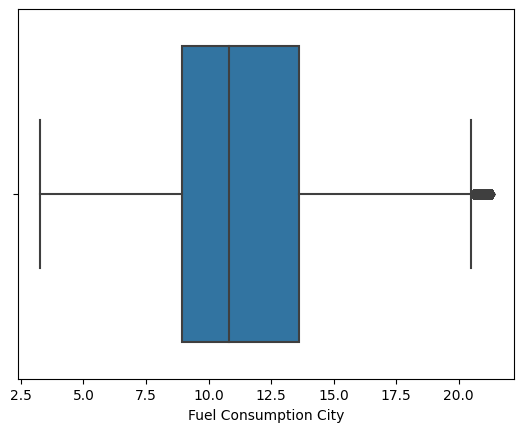

In [1292]:
import seaborn as sns

sns.boxplot(data=train, x='Fuel Consumption City')


In [1293]:
# train[train['City Imputed'] == True]['Fuel Consumption City'].describe()

In [1294]:
# city_asli = train[train['City Imputed'] == False]['Fuel Consumption City']
# city_imputed = train[train['City Imputed'] == True]['Fuel Consumption City']
# city_asli.plot(kind='kde')
# city_imputed.plot(kind='kde')

In [1295]:
# train['Fuel Consumption City'].plot(kind='kde')

In [1296]:
# train[train['City Imputed']]

In [1297]:
# Hwy_asli = train[train['Hwy Imputed'] == False]['Fuel Consumption Hwy']
# Hwy_imputed = train[train['Hwy Imputed'] == True]['Fuel Consumption Hwy']
# Hwy_asli.plot(kind='kde')
# Hwy_imputed.plot(kind='kde')

In [1298]:
# Comb_asli = train[train['Comb Imputed'] == False]['Fuel Consumption Comb']
# Comb_imputed = train[train['Comb Imputed'] == True]['Fuel Consumption Comb']
# Comb_asli.plot(kind='kde')
# Comb_imputed.plot(kind='kde')

In [1299]:
# city_asli.describe()

In [1300]:
# city_imputed.describe()

In [1301]:
# Hwy_asli.describe()

In [1302]:
# Hwy_imputed.describe()

In [1303]:
# train.loc[~(train['City Imputed']) & ~(train['Hwy Imputed']) & (train['Comb Imputed']), 'Fuel Consumption Comb'] = (11*train['Fuel Consumption City']+9*train['Fuel Consumption Hwy'])/20
# train.loc[(train['City Imputed']) & ~(train['Hwy Imputed']) & (train['Comb Imputed']), 'Fuel Consumption City'] = (20*train['Fuel Consumption Comb']-9*train['Fuel Consumption Hwy'])/11
# train.loc[~(train['City Imputed']) & (train['Hwy Imputed']) & (train['Comb Imputed']), 'Fuel Consumption Hwy'] = (20*train['Fuel Consumption Comb']-11*train['Fuel Consumption City'])/9

In [1304]:
# train['Fuel Consumption City'].values[train['Fuel Consumption City'] < 0] = np.nan
# train['Fuel Consumption Hwy'].values[train['Fuel Consumption Hwy'] < 0] = np.nan
# test['Fuel Consumption City'].values[test['Fuel Consumption City'] < 0] = np.nan
# test['Fuel Consumption Hwy'].values[test['Fuel Consumption Hwy'] < 0] = np.nan

<Axes: >

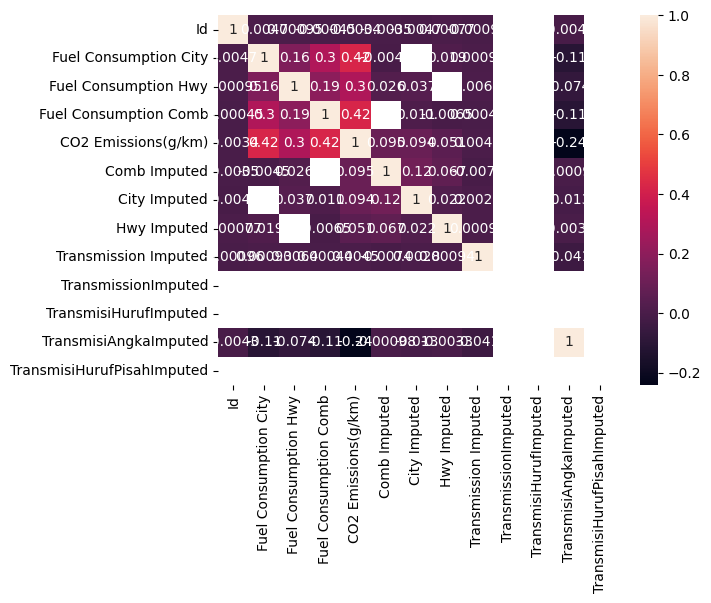

In [1305]:
sns.heatmap(train.corr(numeric_only=True), annot=True)

In [1306]:
train.loc[train['City Imputed'], 'Fuel Consumption City'] = train.groupby('Vehicle Class')['Fuel Consumption City'].transform('median')
train.loc[train['Hwy Imputed'], 'Fuel Consumption Hwy'] = train.groupby('Vehicle Class')['Fuel Consumption Hwy'].transform('median')
train.loc[train['Comb Imputed'], 'Fuel Consumption Comb'] = train.groupby('Vehicle Class')['Fuel Consumption Comb'].transform('median')

In [1307]:
train['City Imputed 2'] = train['Fuel Consumption City'].isnull()
train['Hwy Imputed 2'] = train['Fuel Consumption Hwy'].isnull()
train['Comb Imputed 2'] = train['Fuel Consumption Comb'].isnull()

In [1308]:
train['Fuel Consumption City'].fillna(train['Fuel Consumption City'].median(), inplace=True)
train['Fuel Consumption Hwy'].fillna(train['Fuel Consumption Hwy'].median(), inplace=True)
train['Fuel Consumption Comb'].fillna(train['Fuel Consumption Comb'].median(), inplace=True)

In [1309]:
train.columns

Index(['Id', 'Make', 'Vehicle Class', 'Engine Size(L)', 'Cylinders',
       'Transmission', 'Fuel Type', 'Fuel Consumption City',
       'Fuel Consumption Hwy', 'Fuel Consumption Comb', 'CO2 Emissions(g/km)',
       'Comb Imputed', 'City Imputed', 'Hwy Imputed', 'Transmission Imputed',
       'TransmisiHuruf', 'TransmisiAngka', 'TransmisiHurufPisah',
       'TransmissionImputed', 'TransmisiHurufImputed', 'TransmisiAngkaImputed',
       'TransmisiHurufPisahImputed', 'City Imputed 2', 'Hwy Imputed 2',
       'Comb Imputed 2'],
      dtype='object')

In [1310]:
test.loc[test['City Imputed'], 'Fuel Consumption City'] = test.groupby('Vehicle Class')['Fuel Consumption City'].transform('median')
test.loc[test['Hwy Imputed'], 'Fuel Consumption Hwy'] = test.groupby('Vehicle Class')['Fuel Consumption Hwy'].transform('median')
test.loc[test['Hwy Imputed'], 'Fuel Consumption Comb'] = test.groupby('Vehicle Class')['Fuel Consumption Comb'].transform('median')

In [1311]:
test['City Imputed 2'] = test['Fuel Consumption City'].isnull()
test['Hwy Imputed 2'] = test['Fuel Consumption Hwy'].isnull()
test['Comb Imputed 2'] = test['Fuel Consumption Comb'].isnull()

In [1312]:
test['Fuel Consumption City'].fillna(test['Fuel Consumption City'].median(), inplace=True)
test['Fuel Consumption Hwy'].fillna(test['Fuel Consumption Hwy'].median(), inplace=True)
test['Fuel Consumption Comb'].fillna(test['Fuel Consumption Comb'].median(), inplace=True)

<Axes: ylabel='Density'>

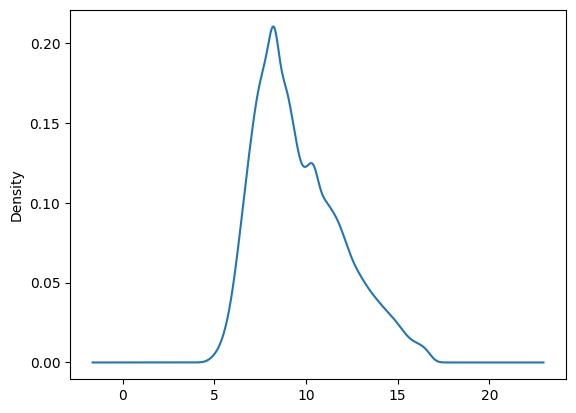

In [1313]:
train['Fuel Consumption Hwy'].plot(kind='kde')

<Axes: ylabel='Density'>

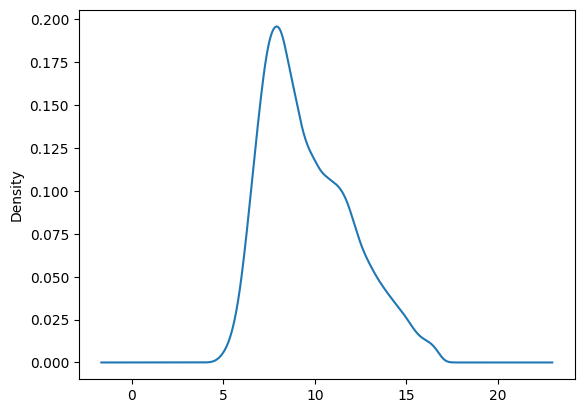

In [1314]:
train[train['Hwy Imputed'] == False]['Fuel Consumption Hwy'].plot(kind='kde')

In [1315]:
train.isna().sum()

Id                               0
Make                             0
Vehicle Class                 2051
Engine Size(L)                5264
Cylinders                     4523
Transmission                     0
Fuel Type                     1942
Fuel Consumption City            0
Fuel Consumption Hwy             0
Fuel Consumption Comb            0
CO2 Emissions(g/km)              0
Comb Imputed                     0
City Imputed                     0
Hwy Imputed                      0
Transmission Imputed             0
TransmisiHuruf                   0
TransmisiAngka                3163
TransmisiHurufPisah              0
TransmissionImputed              0
TransmisiHurufImputed            0
TransmisiAngkaImputed            0
TransmisiHurufPisahImputed       0
City Imputed 2                   0
Hwy Imputed 2                    0
Comb Imputed 2                   0
dtype: int64

In [1316]:
train[train['TransmisiAngka'].isna() & ~train['TransmisiHuruf'].isna()]

,Id,Make,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,...,TransmisiHuruf,TransmisiAngka,TransmisiHurufPisah,TransmissionImputed,TransmisiHurufImputed,TransmisiAngkaImputed,TransmisiHurufPisahImputed,City Imputed 2,Hwy Imputed 2,Comb Imputed 2
17,18,MITSU,COMPACT,1.2,3.0,AV,X,12.660000,12.660000,7.900000,...,AV,NaN,A,False,False,True,False,False,False,False
24,25,GONDA,FULL-SIZE,1.5,4.0,AV,X,4.200179,14.710000,10.360000,...,AV,NaN,A,False,False,True,False,False,False,False
45,46,TOYOTI,COMPACT,1.8,4.0,AV,X,10.599820,8.100946,9.470000,...,AV,NaN,A,False,False,True,False,False,False,False
51,52,CHEVO,SUBCOMPACT,1.4,4.0,AV,X,10.310000,7.300000,8.620000,...,AV,NaN,A,False,False,True,False,False,False,False
57,58,TOYOTI,MID-SIZE,1.8,4.0,AV,X,7.200000,5.500000,15.540000,...,AV,NaN,A,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54828,54829,TOYOTI,MID-SIZE,2.5,4.0,AV,X,11.500000,6.899853,9.430000,...,AV,NaN,A,False,False,True,False,False,False,False
54830,54831,NIRRAN,SUV - SMALL,3.5,6.0,AV,X,9.800000,8.600000,9.260236,...,AV,NaN,A,False,False,True,False,False,False,False
54841,54842,NIRRAN,SUV - SMALL,3.5,6.0,AV,X,6.290000,11.100000,13.740000,...,AV,NaN,A,False,False,True,False,False,False,False
54843,54844,GONDA,FULL-SIZE,1.5,4.0,AV,X,8.770000,7.000000,9.400000,...,AV,NaN,A,False,False,True,False,False,False,False


In [1317]:
train[train['TransmisiAngka'].isna() & ~train['TransmisiHuruf'].isna()]['TransmisiHuruf'].unique()

array(['AV'], dtype=object)

In [1318]:
test[test['TransmisiAngka'].isna() & ~test['TransmisiHuruf'].isna()]['TransmisiHuruf'].unique()

array(['AV'], dtype=object)

In [1319]:
train.loc[(train['TransmisiAngka'].isna()) & (~train['TransmisiHuruf'].isna()), 'TransmisiAngka'] = 0
test.loc[(test['TransmisiAngka'].isna()) & (~test['TransmisiHuruf'].isna()), 'TransmisiAngka'] = 0

In [1320]:
train['Fuel Type Imputed'] = train['Fuel Type'].isnull()
test['Fuel Type Imputed'] = test['Fuel Type'].isnull()

In [1321]:
train["Fuel Type"] = train.groupby(
    "Make")["Fuel Type"].transform(lambda x: x.fillna(x.mode()[0]))
test["Fuel Type"] = test.groupby(
    "Make")["Fuel Type"].transform(lambda x: x.fillna(x.mode()[0]))

In [1322]:
train.groupby('Make')['Fuel Type'].value_counts()

Make          Fuel Type
ASURA         Z             848
BARUSU        X            1045
              Z             465
BMV           Z            5722
              D             212
CADILUXE      Z            1118
              X             695
              E              23
CHEVO         X            4531
              Z             974
              E             784
              D             323
              N               9
DOGE          X            1664
              Z             729
              E             437
FIAR          X             803
FOLD          X            5701
              E            1215
              Z             166
              D             151
FOLKSWA       X            1449
              Z             571
              D             228
GONDA         X            2282
              Z             212
JIPU          X            2545
              E             134
              Z             122
              D              67
KIO           X 

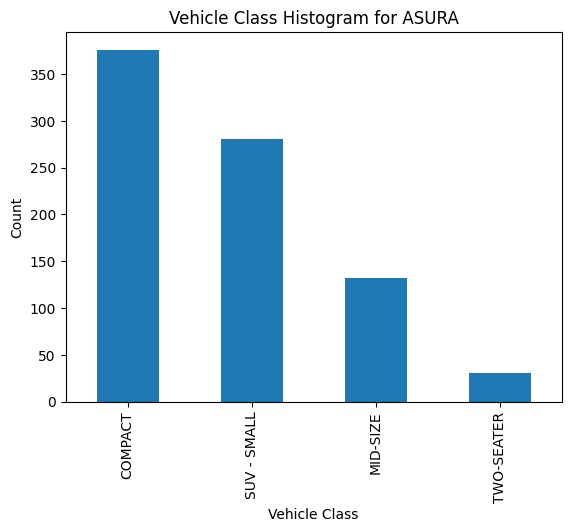

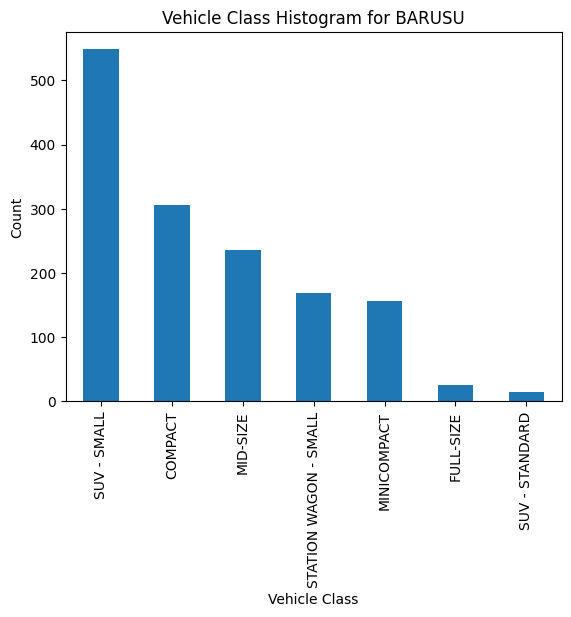

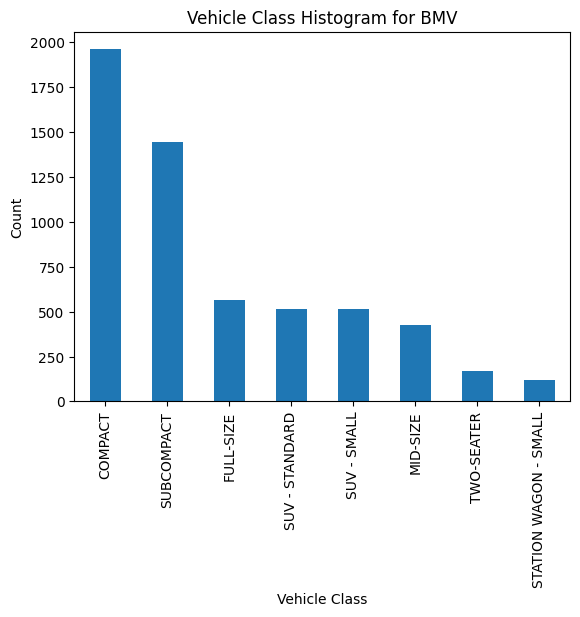

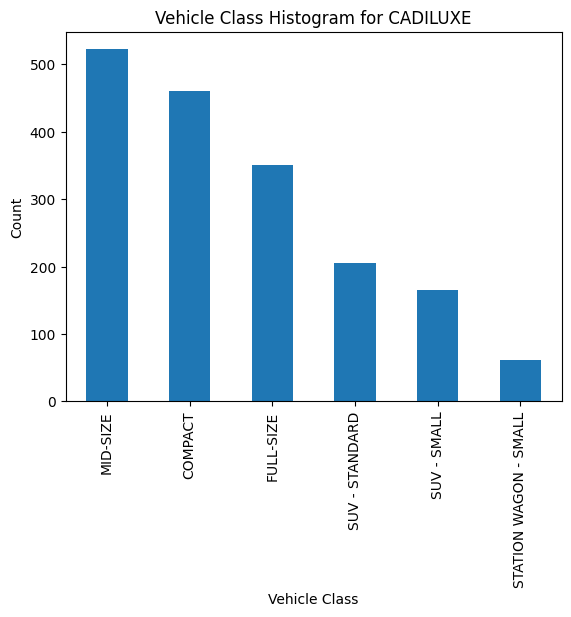

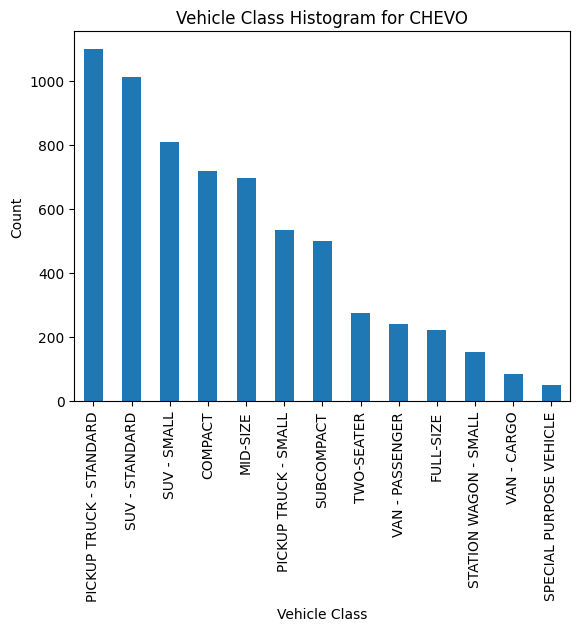

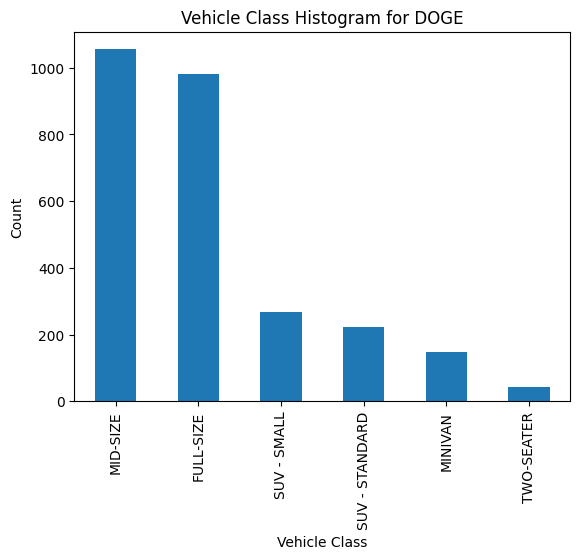

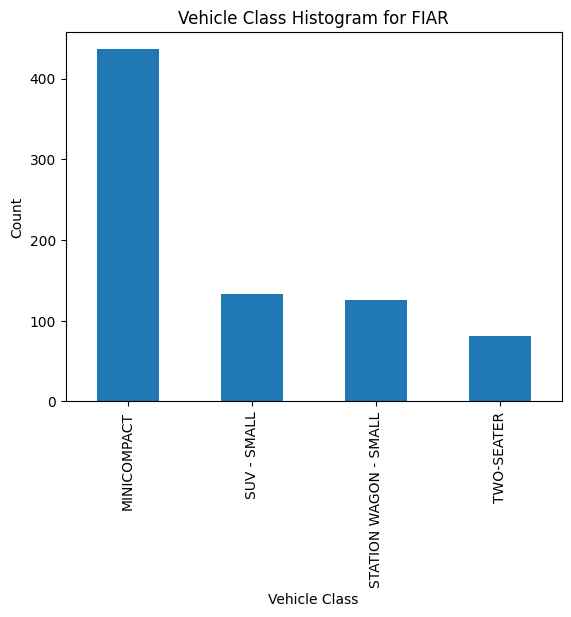

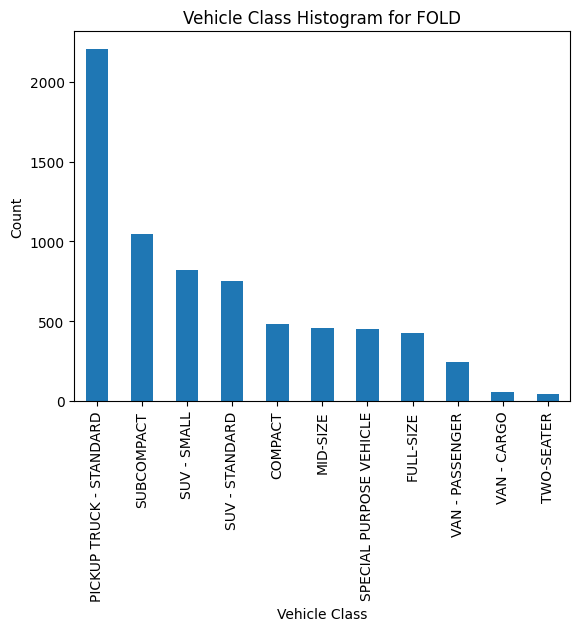

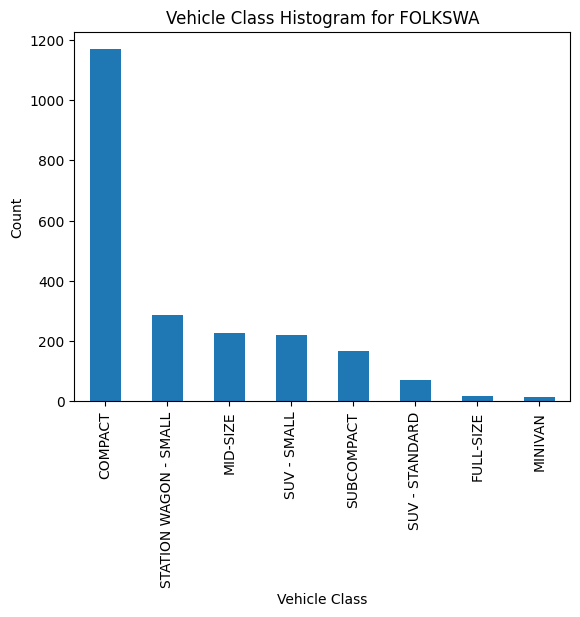

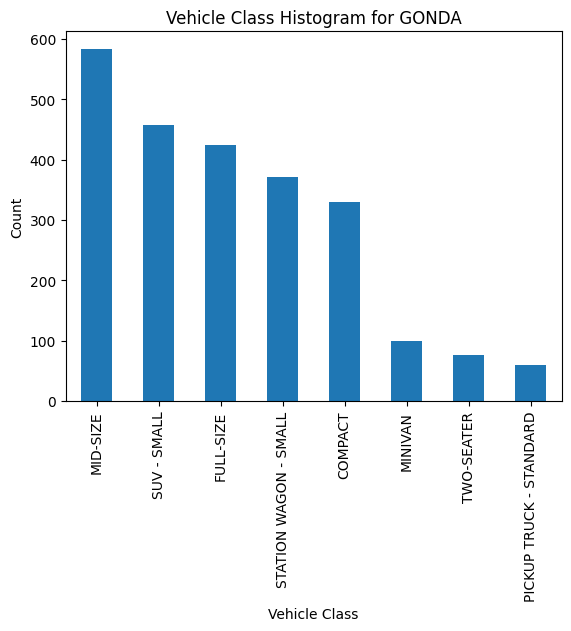

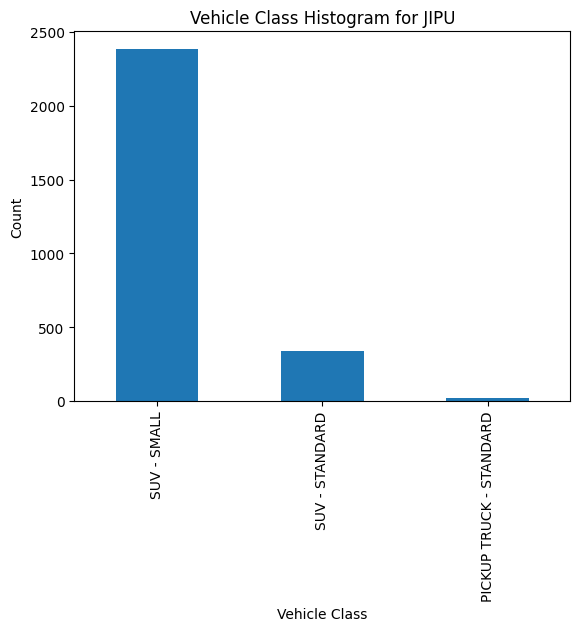

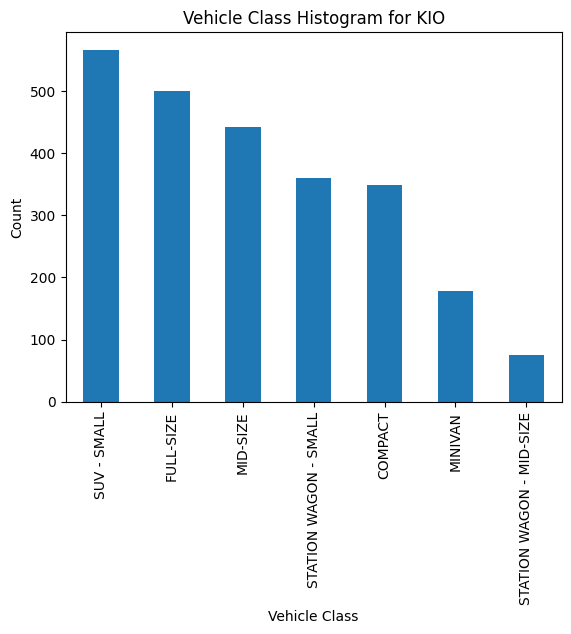

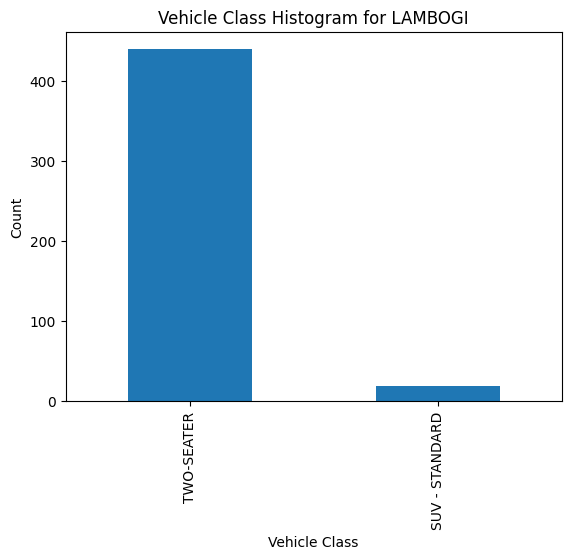

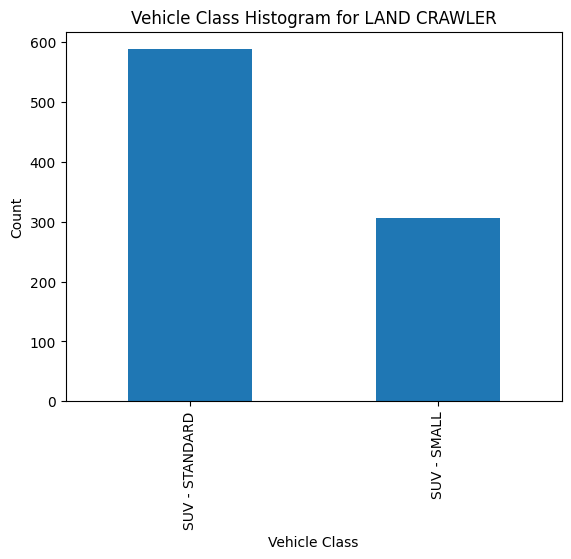

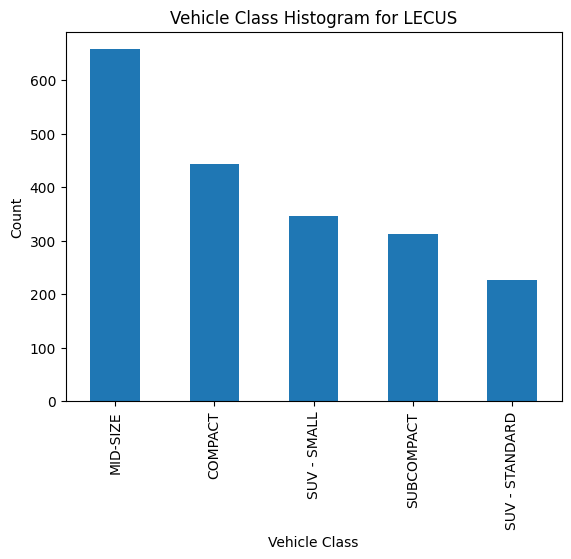

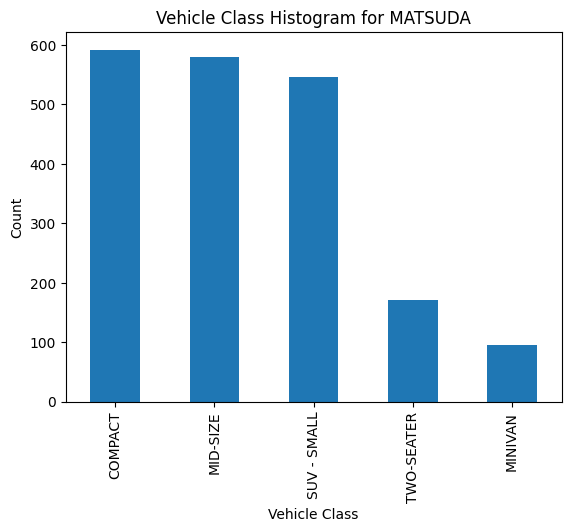

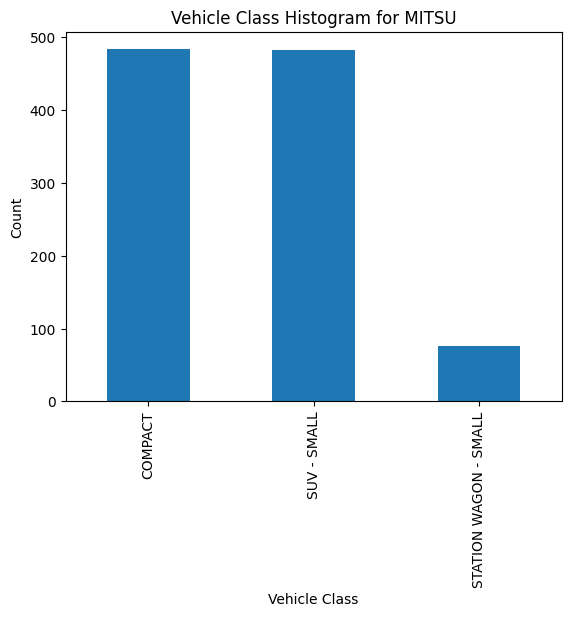

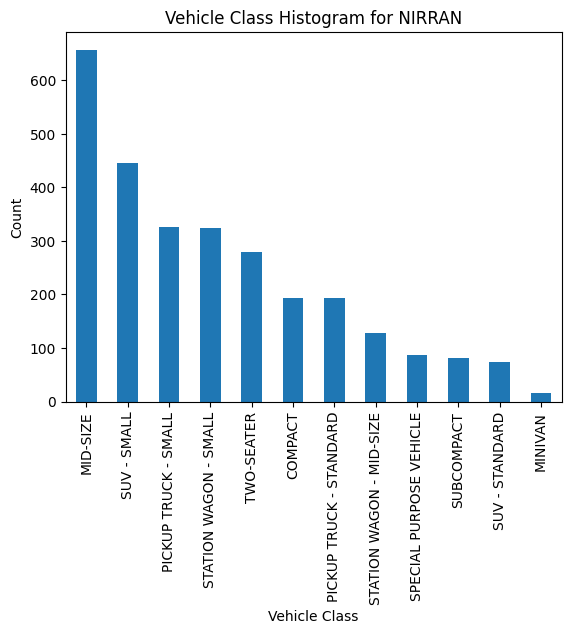

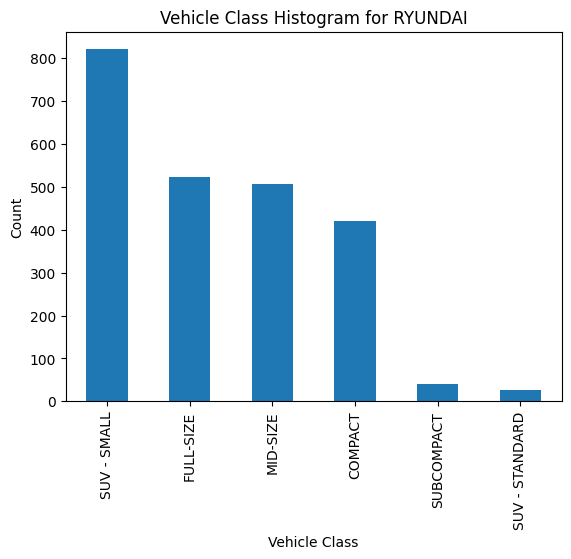

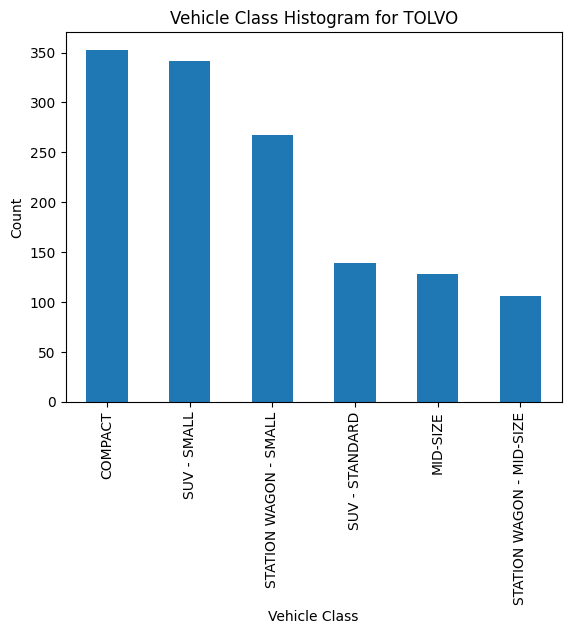

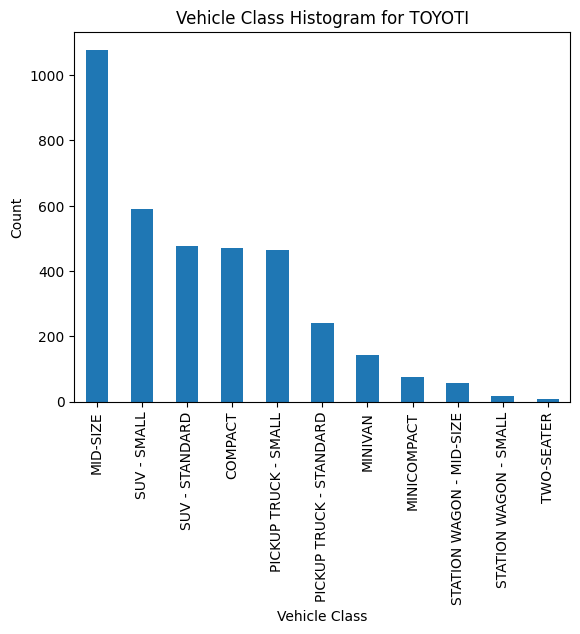

In [1323]:
import matplotlib.pyplot as plt

make_vehicle_class_counts = train.groupby('Make')['Vehicle Class'].value_counts()

for make in make_vehicle_class_counts.index.levels[0]:
    plt.figure()
    make_vehicle_class_counts[make].plot(kind='bar')
    plt.title(f'Vehicle Class Histogram for {make}')
    plt.xlabel('Vehicle Class')
    plt.ylabel('Count')
    plt.show()


In [1324]:
train.isna().sum()

Id                               0
Make                             0
Vehicle Class                 2051
Engine Size(L)                5264
Cylinders                     4523
Transmission                     0
Fuel Type                        0
Fuel Consumption City            0
Fuel Consumption Hwy             0
Fuel Consumption Comb            0
CO2 Emissions(g/km)              0
Comb Imputed                     0
City Imputed                     0
Hwy Imputed                      0
Transmission Imputed             0
TransmisiHuruf                   0
TransmisiAngka                   0
TransmisiHurufPisah              0
TransmissionImputed              0
TransmisiHurufImputed            0
TransmisiAngkaImputed            0
TransmisiHurufPisahImputed       0
City Imputed 2                   0
Hwy Imputed 2                    0
Comb Imputed 2                   0
Fuel Type Imputed                0
dtype: int64

In [1325]:
train['TransmisiHuruf'].value_counts()

TransmisiHuruf
AS    25164
A     11140
M      9885
AV     6043
AM     2705
Name: count, dtype: int64

In [1326]:
train[train['TransmisiHuruf']=='AS']['TransmisiAngka'].value_counts()

TransmisiAngka
6     13719
8      8335
10     1848
9       673
7       308
5       281
Name: count, dtype: int64

In [1327]:
train['TransmisiAngka'].unique()

array(['8', '5', '6', '9', 0, '10', '7', '4'], dtype=object)

In [1328]:
# test['Transmission'].fillna('AS6', inplace=True)
# test['TransmisiHuruf'].fillna('AS', inplace=True)
# test['TransmisiHurufPisah'].fillna('A', inplace=True)
# test['TransmisiAngka'].fillna('6', inplace=True)

In [1329]:
train['Vehicle Class Imputed'] = train['Vehicle Class'].isnull()
test['Vehicle Class Imputed'] = test['Vehicle Class'].isnull()

In [1330]:
train.loc[train['Vehicle Class Imputed'], 'Vehicle Class'] = train.groupby('Make')['Vehicle Class'].transform(lambda x: x.mode()[0])
test.loc[test['Vehicle Class Imputed'], 'Vehicle Class'] = test.groupby('Make')['Vehicle Class'].transform(lambda x: x.mode()[0])

In [1331]:
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)


In [1332]:
train.isna().sum()

Make                             0
Vehicle Class                    0
Engine Size(L)                5264
Cylinders                     4523
Transmission                     0
Fuel Type                        0
Fuel Consumption City            0
Fuel Consumption Hwy             0
Fuel Consumption Comb            0
CO2 Emissions(g/km)              0
Comb Imputed                     0
City Imputed                     0
Hwy Imputed                      0
Transmission Imputed             0
TransmisiHuruf                   0
TransmisiAngka                   0
TransmisiHurufPisah              0
TransmissionImputed              0
TransmisiHurufImputed            0
TransmisiAngkaImputed            0
TransmisiHurufPisahImputed       0
City Imputed 2                   0
Hwy Imputed 2                    0
Comb Imputed 2                   0
Fuel Type Imputed                0
Vehicle Class Imputed            0
dtype: int64

In [1333]:
test.isna().sum()

Make                             0
Vehicle Class                    0
Engine Size(L)                2269
Cylinders                     1894
Transmission                     0
Fuel Type                        0
Fuel Consumption City            0
Fuel Consumption Hwy             0
Fuel Consumption Comb            0
Comb Imputed                     0
City Imputed                     0
Hwy Imputed                      0
Transmission Imputed             0
TransmisiHuruf                   0
TransmisiAngka                   0
TransmisiHurufPisah              0
TransmissionImputed              0
TransmisiHurufImputed            0
TransmisiAngkaImputed            0
TransmisiHurufPisahImputed       0
City Imputed 2                   0
Hwy Imputed 2                    0
Comb Imputed 2                   0
Fuel Type Imputed                0
Vehicle Class Imputed            0
dtype: int64

In [1334]:
train.dtypes

Make                           object
Vehicle Class                  object
Engine Size(L)                 object
Cylinders                      object
Transmission                   object
Fuel Type                      object
Fuel Consumption City         float64
Fuel Consumption Hwy          float64
Fuel Consumption Comb         float64
CO2 Emissions(g/km)             int64
Comb Imputed                     bool
City Imputed                     bool
Hwy Imputed                      bool
Transmission Imputed             bool
TransmisiHuruf                 object
TransmisiAngka                 object
TransmisiHurufPisah            object
TransmissionImputed              bool
TransmisiHurufImputed            bool
TransmisiAngkaImputed            bool
TransmisiHurufPisahImputed       bool
City Imputed 2                   bool
Hwy Imputed 2                    bool
Comb Imputed 2                   bool
Fuel Type Imputed                bool
Vehicle Class Imputed            bool
dtype: objec

In [1335]:
train['Cylinders'].unique()

array(['4.0', '6.0', '8.0', nan, '3.0', '10.0', '12.0', '5.0'],
      dtype=object)

In [1336]:
train['Engine Size(L)'] = train['Engine Size(L)'].astype(float)
train['Cylinders'] = train['Cylinders'].astype(float)

In [1337]:
train.isna().sum()

Make                             0
Vehicle Class                    0
Engine Size(L)                5264
Cylinders                     4523
Transmission                     0
Fuel Type                        0
Fuel Consumption City            0
Fuel Consumption Hwy             0
Fuel Consumption Comb            0
CO2 Emissions(g/km)              0
Comb Imputed                     0
City Imputed                     0
Hwy Imputed                      0
Transmission Imputed             0
TransmisiHuruf                   0
TransmisiAngka                   0
TransmisiHurufPisah              0
TransmissionImputed              0
TransmisiHurufImputed            0
TransmisiAngkaImputed            0
TransmisiHurufPisahImputed       0
City Imputed 2                   0
Hwy Imputed 2                    0
Comb Imputed 2                   0
Fuel Type Imputed                0
Vehicle Class Imputed            0
dtype: int64

In [1338]:
target = train['CO2 Emissions(g/km)']
train = train.drop('CO2 Emissions(g/km)', axis=1)

In [1339]:
train.dtypes

Make                           object
Vehicle Class                  object
Engine Size(L)                float64
Cylinders                     float64
Transmission                   object
Fuel Type                      object
Fuel Consumption City         float64
Fuel Consumption Hwy          float64
Fuel Consumption Comb         float64
Comb Imputed                     bool
City Imputed                     bool
Hwy Imputed                      bool
Transmission Imputed             bool
TransmisiHuruf                 object
TransmisiAngka                 object
TransmisiHurufPisah            object
TransmissionImputed              bool
TransmisiHurufImputed            bool
TransmisiAngkaImputed            bool
TransmisiHurufPisahImputed       bool
City Imputed 2                   bool
Hwy Imputed 2                    bool
Comb Imputed 2                   bool
Fuel Type Imputed                bool
Vehicle Class Imputed            bool
dtype: object

In [1340]:
# List column that are object datatype
col_object = train.select_dtypes(include=['object']).columns

# One hot encode the col list that are object datatype
# keep the nan columns to be nan on the one hot encode columns
train = pd.get_dummies(train, columns=col_object)
test = pd.get_dummies(test, columns=col_object)

In [1341]:
train.dtypes

Engine Size(L)           float64
Cylinders                float64
Fuel Consumption City    float64
Fuel Consumption Hwy     float64
Fuel Consumption Comb    float64
                          ...   
TransmisiAngka_7            bool
TransmisiAngka_8            bool
TransmisiAngka_9            bool
TransmisiHurufPisah_A       bool
TransmisiHurufPisah_M       bool
Length: 100, dtype: object

In [1352]:
# Initialize models
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
import catboost as cb
import xgboost as xgb


models = {
    'bernoulli': cb.CatBoostRegressor(),
    
}

# Perform cross-validation
for name, model in models.items():
    print(name, ':', -cross_val_score(model, train, target, cv=5, scoring="neg_root_mean_squared_error"))

Learning rate set to 0.074433
0:	learn: 64.0661533	total: 5.49ms	remaining: 5.49s
1:	learn: 60.8077081	total: 11.6ms	remaining: 5.76s
2:	learn: 57.7673076	total: 18.4ms	remaining: 6.13s
3:	learn: 55.0381820	total: 23.5ms	remaining: 5.85s
4:	learn: 52.5979743	total: 29.3ms	remaining: 5.82s
5:	learn: 50.4225044	total: 34.5ms	remaining: 5.71s
6:	learn: 48.4075662	total: 39.5ms	remaining: 5.61s
7:	learn: 46.5741988	total: 45.1ms	remaining: 5.6s
8:	learn: 44.9330961	total: 51.2ms	remaining: 5.63s
9:	learn: 43.3990361	total: 55.8ms	remaining: 5.52s
10:	learn: 42.0023497	total: 61.8ms	remaining: 5.55s
11:	learn: 40.7204039	total: 66.2ms	remaining: 5.45s
12:	learn: 39.6294598	total: 70.5ms	remaining: 5.35s
13:	learn: 38.5666869	total: 76.6ms	remaining: 5.4s
14:	learn: 37.6594171	total: 82.2ms	remaining: 5.39s
15:	learn: 36.7689048	total: 87.3ms	remaining: 5.37s
16:	learn: 35.9862787	total: 92.7ms	remaining: 5.36s
17:	learn: 35.3073349	total: 97.8ms	remaining: 5.33s
18:	learn: 34.6731847	total:

In [1343]:
import numpy as np
array = np.array([19.86057995, 20.26185411, 19.83539803, 19.72630071, 20.05723233])
mean = np.mean(array)
mean

19.948273026000003

In [1344]:
train.columns

Index(['Engine Size(L)', 'Cylinders', 'Fuel Consumption City',
       'Fuel Consumption Hwy', 'Fuel Consumption Comb', 'Comb Imputed',
       'City Imputed', 'Hwy Imputed', 'Transmission Imputed',
       'TransmissionImputed', 'TransmisiHurufImputed', 'TransmisiAngkaImputed',
       'TransmisiHurufPisahImputed', 'City Imputed 2', 'Hwy Imputed 2',
       'Comb Imputed 2', 'Fuel Type Imputed', 'Vehicle Class Imputed',
       'Make_ASURA', 'Make_BARUSU', 'Make_BMV', 'Make_CADILUXE', 'Make_CHEVO',
       'Make_DOGE', 'Make_FIAR', 'Make_FOLD', 'Make_FOLKSWA', 'Make_GONDA',
       'Make_JIPU', 'Make_KIO', 'Make_LAMBOGI', 'Make_LAND CRAWLER',
       'Make_LECUS', 'Make_MATSUDA', 'Make_MITSU', 'Make_NIRRAN',
       'Make_RYUNDAI', 'Make_TOLVO', 'Make_TOYOTI', 'Vehicle Class_COMPACT',
       'Vehicle Class_FULL-SIZE', 'Vehicle Class_MID-SIZE',
       'Vehicle Class_MINICOMPACT', 'Vehicle Class_MINIVAN',
       'Vehicle Class_PICKUP TRUCK - SMALL',
       'Vehicle Class_PICKUP TRUCK - STANDARD',

In [1345]:
test.columns

Index(['Engine Size(L)', 'Cylinders', 'Fuel Consumption City',
       'Fuel Consumption Hwy', 'Fuel Consumption Comb', 'Comb Imputed',
       'City Imputed', 'Hwy Imputed', 'Transmission Imputed',
       'TransmissionImputed', 'TransmisiHurufImputed', 'TransmisiAngkaImputed',
       'TransmisiHurufPisahImputed', 'City Imputed 2', 'Hwy Imputed 2',
       'Comb Imputed 2', 'Fuel Type Imputed', 'Vehicle Class Imputed',
       'Make_ASURA', 'Make_BARUSU', 'Make_BMV', 'Make_CADILUXE', 'Make_CHEVO',
       'Make_DOGE', 'Make_FIAR', 'Make_FOLD', 'Make_FOLKSWA', 'Make_GONDA',
       'Make_JIPU', 'Make_KIO', 'Make_LAMBOGI', 'Make_LAND CRAWLER',
       'Make_LECUS', 'Make_MATSUDA', 'Make_MITSU', 'Make_NIRRAN',
       'Make_RYUNDAI', 'Make_TOLVO', 'Make_TOYOTI', 'Vehicle Class_COMPACT',
       'Vehicle Class_FULL-SIZE', 'Vehicle Class_MID-SIZE',
       'Vehicle Class_MINICOMPACT', 'Vehicle Class_MINIVAN',
       'Vehicle Class_PICKUP TRUCK - SMALL',
       'Vehicle Class_PICKUP TRUCK - STANDARD',

In [1346]:
# model = cb.CatBoostRegressor(cat_features=train.select_dtypes(include=['object']).columns.tolist())
# model.fit(train, target)
# pred = model.predict(test)

In [1347]:
# sample = pd.read_csv('sample_submission.csv')
# sample['CO2 Emissions(g/km)'] = pred
# sample.to_csv('submission7.csv', index=False)